Import Libraries and Set Up Environment

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
import os
import json
from datetime import datetime
from tqdm import tqdm
import warnings
from transformers import BertConfig, BertModel
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/home/johanubuntu/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-02 20:57:28.513357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735826248.525372    9023 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735826248.528763    9023 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 20:57:28.541970: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical oper

Using device: cuda


Load and information data

In [2]:
# Load data
df = pd.read_csv('./Dataset/UNSW_NB15_training-set.csv')

# Display basic information about the dataset
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

Define Feature Modalities

In [3]:
# Define feature modalities
MODALITIES = {
    'flow_features': [
        'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate',
        'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss'
    ],
    'time_features': [
        'sinpkt', 'dinpkt', 'sjit', 'djit'
    ],
    'window_features': [
        'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat'
    ],
    'packet_features': [
        'smean', 'dmean'
    ],
    'connection_features': [
        'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl',
        'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm'
    ],
    'protocol_features': [
        'proto', 'service', 'state'
    ],
    'ftp_features': [
        'is_ftp_login', 'ct_ftp_cmd'
    ],
    'http_features': [
        'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'
    ]
}

Preprocess Data

In [4]:
# Convert binary labels
df['label'] = df['label'].map({0: 'Normal', 1: 'Ransomware'})

# Split data into training and testing sets (80:20)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Preprocess the dataset by modality
def preprocess_modalities(df: pd.DataFrame) -> Tuple[Dict[str, np.ndarray], np.ndarray]:
    processed_data = {}

    # Process each modality separately
    for modality, features in MODALITIES.items():
        # Get features for current modality
        modal_data = df[features].copy()

        # Handle categorical features
        categorical_cols = modal_data.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            le = LabelEncoder()
            modal_data[col] = le.fit_transform(modal_data[col].astype(str))

        # Normalize numerical features
        scaler = MinMaxScaler()
        processed_data[modality] = scaler.fit_transform(modal_data)

    # Process labels
    le_labels = LabelEncoder()
    labels = le_labels.fit_transform(df['label'])

    return processed_data, labels

# Process training data by modality
processed_train_data, train_labels = preprocess_modalities(train_df)

# Process test data by modality
processed_test_data, test_labels = preprocess_modalities(test_df)

Create the MultiModalDataset Class

In [5]:
# Create a custom dataset class for multi-modal data
class MultiModalDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor], labels: torch.Tensor):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.data.items()}, self.labels[idx]

Define the ModalityEncoder Class

In [6]:
class BertTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.bert_config = BertConfig(
            hidden_size=hidden_dim,
            num_attention_heads=4,
            intermediate_size=512,
            num_hidden_layers=2
        )
        self.encoder = BertModel(self.bert_config)
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        self.position_embeddings = nn.Parameter(torch.randn(1, 1, hidden_dim))
        
    def forward(self, x):
        x = self.input_projection(x)
        x = x.unsqueeze(1)  # Add sequence dimension
        x = x + self.position_embeddings
        outputs = self.encoder(inputs_embeds=x)
        return outputs.last_hidden_state.squeeze(1)

Define the MultiModalTransformer Class

In [7]:
class MultiModalBertTransformer(nn.Module):
    def __init__(self, modality_dims, hidden_dim=128):
        super().__init__()
        self.transformers = nn.ModuleDict({
            modality: BertTransformer(input_dim, hidden_dim)
            for modality, input_dim in modality_dims.items()
        })
        
        # The combined dimension will be the sum of hidden dimensions for each modality
        combined_dim = hidden_dim * len(modality_dims)
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 2)  # Assuming binary classification
        )

    def forward(self, inputs):
        features = [transformer(inputs[modality]) for modality, transformer in self.transformers.items()]
        combined = torch.cat(features, dim=1)  # Concatenate along the feature dimension
        return self.classifier(combined)


Define Training and Validation Functions

In [8]:
# Define the training function for one epoch
def train_epoch(model: nn.Module,
                train_loader: DataLoader,
                criterion: nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> Tuple[float, float]:
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_data, labels in tqdm(train_loader, desc="Training", leave=False):
        # Move data to device
        batch_data = {
            modality: features.to(device).float()
            for modality, features in batch_data.items()
        }
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(train_loader), correct / total

# Define the validation function
def validate(model: nn.Module,
             val_loader: DataLoader,
             criterion: nn.Module,
             device: torch.device) -> Tuple[float, float, List[int], List[float]]:
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch_data, labels in tqdm(val_loader, desc="Validating", leave=False):
            # Move data to device
            batch_data = {
                modality: features.to(device).float()
                for modality, features in batch_data.items()
            }
            labels = labels.to(device)

            outputs = model(batch_data)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

    return total_loss / len(val_loader), correct / total, all_labels, all_preds, all_probs

Define ModelCheckpoint and TrainingHistory Classes

In [9]:
# Define a class to handle model checkpoints
class ModelCheckpoint:
    def __init__(self, filepath: str):
        self.filepath = filepath
        self.best_val_acc = 0

    def save_checkpoint(self, model: nn.Module, val_acc: float, fold: int, epoch: int):
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'val_accuracy': val_acc,
                'fold': fold,
                'epoch': epoch,
                'timestamp': datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            }
            os.makedirs(os.path.dirname(self.filepath), exist_ok=True)
            torch.save(checkpoint, self.filepath)
            return True
        return False

# Define a class to handle training history
class TrainingHistory:
    def __init__(self):
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'fold_metrics': {}
        }

    def update(self, fold: int, epoch: int, metrics: Dict):
        if fold not in self.history['fold_metrics']:
            self.history['fold_metrics'][fold] = []

        self.history['fold_metrics'][fold].append({
            'epoch': epoch + 1,  # Adjust epoch to start from 1
            **metrics
        })

    def plot_metrics(self, fold: int):
        metrics = pd.DataFrame(self.history['fold_metrics'][fold])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        ax1.plot(metrics['epoch'], metrics['train_loss'], label='Training Loss')
        ax1.plot(metrics['epoch'], metrics['val_loss'], label='Validation Loss')
        ax1.set_title(f'Model Loss - Fold {fold + 1}')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Accuracy plot
        ax2.plot(metrics['epoch'], metrics['train_acc'], label='Training Accuracy')
        ax2.plot(metrics['epoch'], metrics['val_acc'], label='Validation Accuracy')
        ax2.set_title(f'Model Accuracy - Fold {fold + 1}')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, fold: int):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold + 1}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def print_classification_report(self, y_true, y_pred, fold: int):
        print(f"\nClassification Report - Fold {fold + 1}")
        print(classification_report(y_true, y_pred))

Define the Training Function with K-Fold Cross-Validation

In [10]:
# Define the training function with k-fold cross-validation
def train_model_with_kfold(
    model: nn.Module,
    dataset: Dataset,
    n_splits: int = 5,
    num_epochs: int = 4,
    batch_size: int = 32,
    device: torch.device = device
) -> Tuple[nn.Module, TrainingHistory]:

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    criterion = nn.CrossEntropyLoss()
    history = TrainingHistory()
    checkpoint = ModelCheckpoint('models/best_model.pth')

    best_fold_metrics = {
        'fold': -1,
        'accuracy': 0,
        'precision': 0,
        'recall': 0,
        'f1': 0,
        'specificity': 0,
        'roc_auc': 0
    }

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\nFold {fold + 1}/{n_splits}")
        print("-" * 40)

        # Create data loaders for this fold
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(
            dataset, batch_size=batch_size, sampler=train_subsampler
        )
        val_loader = DataLoader(
            dataset, batch_size=batch_size, sampler=val_subsampler
        )

        # Reset model for each fold
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

        for epoch in range(num_epochs):
            # Training
            train_loss, train_acc = train_epoch(
                model, train_loader, criterion, optimizer, device
            )

            # Validation
            val_loss, val_acc, val_labels, val_preds, val_probs = validate(
                model, val_loader, criterion, device
            )

            # Update history
            history.update(fold, epoch, {
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc
            })

            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
            print("-" * 40)

            # Save checkpoint if best model
            checkpoint.save_checkpoint(model, val_acc, fold, epoch)

        # Calculate final metrics for this fold
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for batch_data, labels in tqdm(val_loader, desc=f"Evaluating Fold {fold + 1}", leave=False):
                batch_data = {k: v.to(device).float() for k, v in batch_data.items()}
                outputs = model(batch_data)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())
                all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted'
        )
        accuracy = accuracy_score(all_labels, all_preds)
        specificity = confusion_matrix(all_labels, all_preds)[0, 0] / (confusion_matrix(all_labels, all_preds)[0, 0] + confusion_matrix(all_labels, all_preds)[0, 1])
        roc_auc = roc_auc_score(all_labels, all_probs)

        # Update best fold metrics
        if accuracy > best_fold_metrics['accuracy']:
            best_fold_metrics.update({
                'fold': fold,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'specificity': specificity,
                'roc_auc': roc_auc
            })

        # Plot fold results
        history.plot_metrics(fold)
        history.plot_confusion_matrix(all_labels, all_preds, fold)
        history.print_classification_report(all_labels, all_preds, fold)

    # Print final report
    print("\nFinal Report")
    print("=" * 40)
    print(f"Best Fold: {best_fold_metrics['fold'] + 1}")
    print(f"Best Accuracy: {best_fold_metrics['accuracy']:.4f}")
    print(f"Best Precision: {best_fold_metrics['precision']:.4f}")
    print(f"Best Recall: {best_fold_metrics['recall']:.4f}")
    print(f"Best F1 Score: {best_fold_metrics['f1']:.4f}")
    print(f"Best Specificity: {best_fold_metrics['specificity']:.4f}")
    print(f"Best ROC-AUC: {best_fold_metrics['roc_auc']:.4f}")

    return model, history

Create the Model and Train with K-Fold Cross-Validation


Fold 1/5
----------------------------------------


Epoch 1/20
Train Loss: 0.2321 - Train Acc: 0.9121 - Val Loss: 0.1802 - Val Acc: 0.9335
----------------------------------------


Epoch 2/20
Train Loss: 0.1718 - Train Acc: 0.9329 - Val Loss: 0.1587 - Val Acc: 0.9364
----------------------------------------


Epoch 3/20
Train Loss: 0.1575 - Train Acc: 0.9357 - Val Loss: 0.1514 - Val Acc: 0.9363
----------------------------------------


Epoch 4/20
Train Loss: 0.1506 - Train Acc: 0.9365 - Val Loss: 0.1407 - Val Acc: 0.9368
----------------------------------------


Epoch 5/20
Train Loss: 0.1449 - Train Acc: 0.9365 - Val Loss: 0.1447 - Val Acc: 0.9364
----------------------------------------


Epoch 6/20
Train Loss: 0.1391 - Train Acc: 0.9376 - Val Loss: 0.1324 - Val Acc: 0.9379
----------------------------------------


Epoch 7/20
Train Loss: 0.1353 - Train Acc: 0.9382 - Val Loss: 0.1290 - Val Acc: 0.9383
----------------------------------------


Epoch 8/20
Train Loss: 0.1315 - Train Acc: 0.9380 - Val Loss: 0.1280 - Val Acc: 0.9390
----------------------------------------


Epoch 9/20
Train Loss: 0.1299 - Train Acc: 0.9387 - Val Loss: 0.1305 - Val Acc: 0.9378
----------------------------------------


Epoch 10/20
Train Loss: 0.1269 - Train Acc: 0.9389 - Val Loss: 0.1258 - Val Acc: 0.9378
----------------------------------------


Epoch 11/20
Train Loss: 0.1260 - Train Acc: 0.9391 - Val Loss: 0.1354 - Val Acc: 0.9401
----------------------------------------


Epoch 12/20
Train Loss: 0.1250 - Train Acc: 0.9394 - Val Loss: 0.1238 - Val Acc: 0.9406
----------------------------------------


Epoch 13/20
Train Loss: 0.1240 - Train Acc: 0.9396 - Val Loss: 0.1236 - Val Acc: 0.9406
----------------------------------------


Epoch 14/20
Train Loss: 0.1237 - Train Acc: 0.9395 - Val Loss: 0.1240 - Val Acc: 0.9410
----------------------------------------


Epoch 15/20
Train Loss: 0.1230 - Train Acc: 0.9394 - Val Loss: 0.1231 - Val Acc: 0.9392
----------------------------------------


Epoch 16/20
Train Loss: 0.1221 - Train Acc: 0.9396 - Val Loss: 0.1226 - Val Acc: 0.9420
----------------------------------------


Epoch 17/20
Train Loss: 0.1219 - Train Acc: 0.9401 - Val Loss: 0.1213 - Val Acc: 0.9421
----------------------------------------


Epoch 18/20
Train Loss: 0.1209 - Train Acc: 0.9407 - Val Loss: 0.1228 - Val Acc: 0.9412
----------------------------------------


Epoch 19/20
Train Loss: 0.1223 - Train Acc: 0.9400 - Val Loss: 0.1200 - Val Acc: 0.9427
----------------------------------------


Epoch 20/20
Train Loss: 0.1206 - Train Acc: 0.9409 - Val Loss: 0.1234 - Val Acc: 0.9385
----------------------------------------


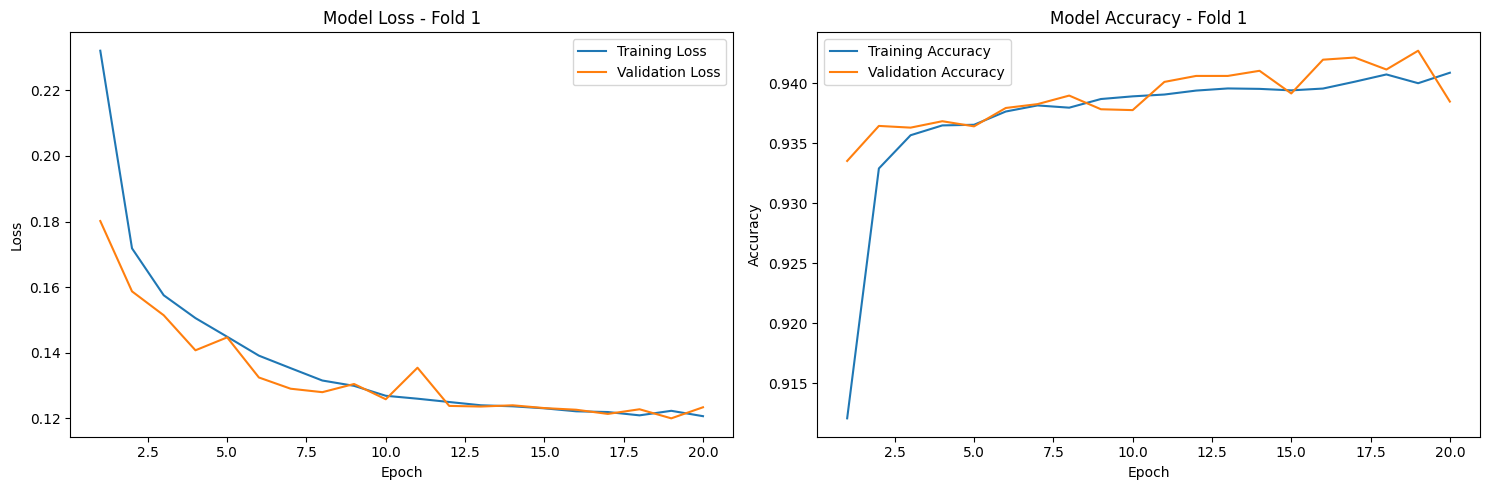

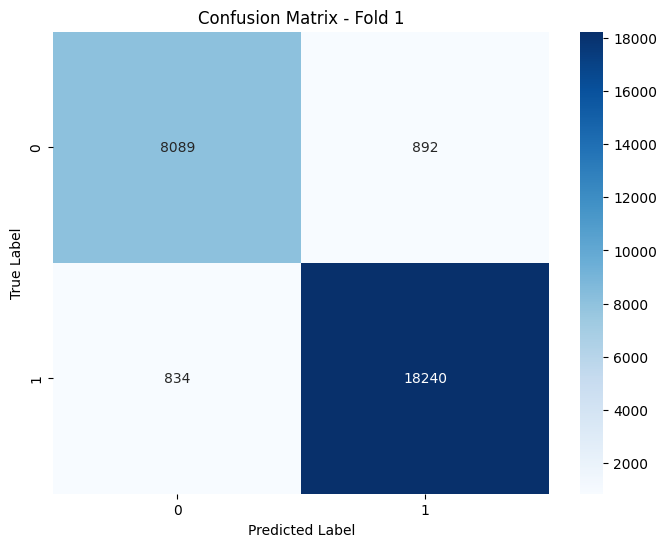


Classification Report - Fold 1
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      8981
           1       0.95      0.96      0.95     19074

    accuracy                           0.94     28055
   macro avg       0.93      0.93      0.93     28055
weighted avg       0.94      0.94      0.94     28055


Fold 2/5
----------------------------------------


Epoch 1/20
Train Loss: 0.2280 - Train Acc: 0.9128 - Val Loss: 0.1702 - Val Acc: 0.9357
----------------------------------------


Epoch 2/20
Train Loss: 0.1676 - Train Acc: 0.9340 - Val Loss: 0.1519 - Val Acc: 0.9362
----------------------------------------


Epoch 3/20
Train Loss: 0.1569 - Train Acc: 0.9358 - Val Loss: 0.1438 - Val Acc: 0.9373
----------------------------------------


Epoch 4/20
Train Loss: 0.1493 - Train Acc: 0.9366 - Val Loss: 0.1379 - Val Acc: 0.9383
----------------------------------------


Epoch 5/20
Train Loss: 0.1439 - Train Acc: 0.9370 - Val Loss: 0.1371 - Val Acc: 0.9382
----------------------------------------


Epoch 6/20
Train Loss: 0.1384 - Train Acc: 0.9377 - Val Loss: 0.1352 - Val Acc: 0.9375
----------------------------------------


Epoch 7/20
Train Loss: 0.1342 - Train Acc: 0.9384 - Val Loss: 0.1303 - Val Acc: 0.9385
----------------------------------------


Epoch 8/20
Train Loss: 0.1312 - Train Acc: 0.9388 - Val Loss: 0.1404 - Val Acc: 0.9367
----------------------------------------


Epoch 9/20
Train Loss: 0.1279 - Train Acc: 0.9394 - Val Loss: 0.1456 - Val Acc: 0.9383
----------------------------------------


Epoch 10/20
Train Loss: 0.1265 - Train Acc: 0.9396 - Val Loss: 0.1161 - Val Acc: 0.9409
----------------------------------------


Epoch 11/20
Train Loss: 0.1250 - Train Acc: 0.9403 - Val Loss: 0.1167 - Val Acc: 0.9417
----------------------------------------


Epoch 12/20
Train Loss: 0.1244 - Train Acc: 0.9402 - Val Loss: 0.1184 - Val Acc: 0.9385
----------------------------------------


Epoch 13/20
Train Loss: 0.1239 - Train Acc: 0.9401 - Val Loss: 0.1202 - Val Acc: 0.9397
----------------------------------------


Epoch 14/20
Train Loss: 0.1232 - Train Acc: 0.9401 - Val Loss: 0.1201 - Val Acc: 0.9402
----------------------------------------


Epoch 15/20
Train Loss: 0.1225 - Train Acc: 0.9403 - Val Loss: 0.1157 - Val Acc: 0.9423
----------------------------------------


Epoch 16/20
Train Loss: 0.1217 - Train Acc: 0.9404 - Val Loss: 0.1151 - Val Acc: 0.9411
----------------------------------------


Epoch 17/20
Train Loss: 0.1220 - Train Acc: 0.9406 - Val Loss: 0.1147 - Val Acc: 0.9432
----------------------------------------


Epoch 18/20
Train Loss: 0.1212 - Train Acc: 0.9409 - Val Loss: 0.1158 - Val Acc: 0.9405
----------------------------------------


Epoch 19/20
Train Loss: 0.1197 - Train Acc: 0.9409 - Val Loss: 0.1247 - Val Acc: 0.9404
----------------------------------------


Epoch 20/20
Train Loss: 0.1213 - Train Acc: 0.9401 - Val Loss: 0.1155 - Val Acc: 0.9423
----------------------------------------


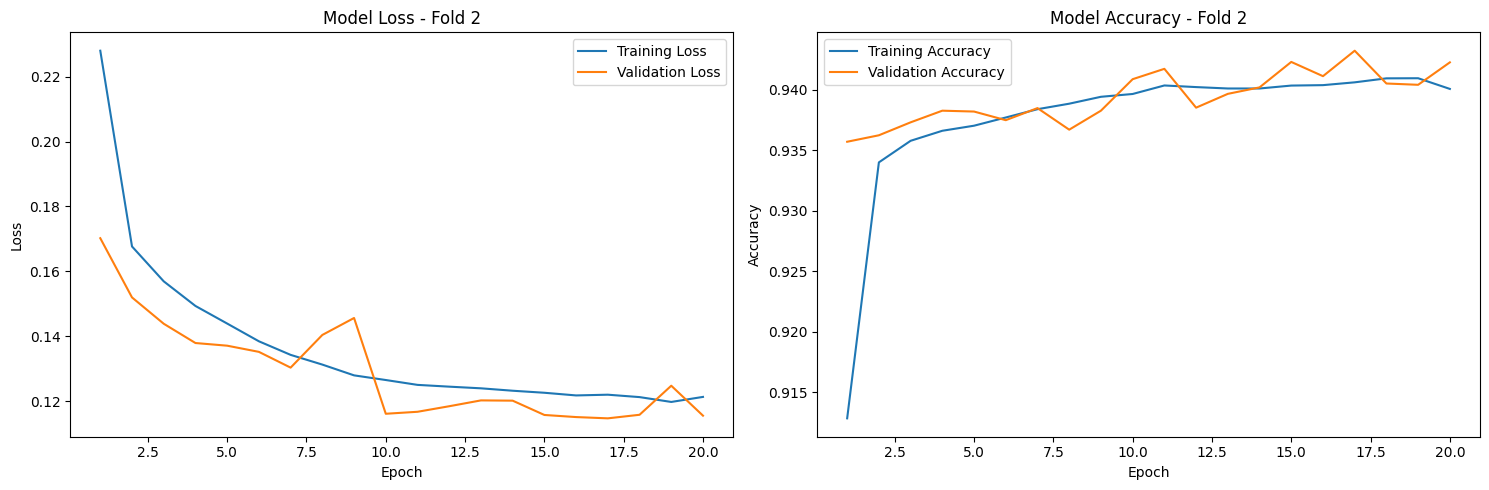

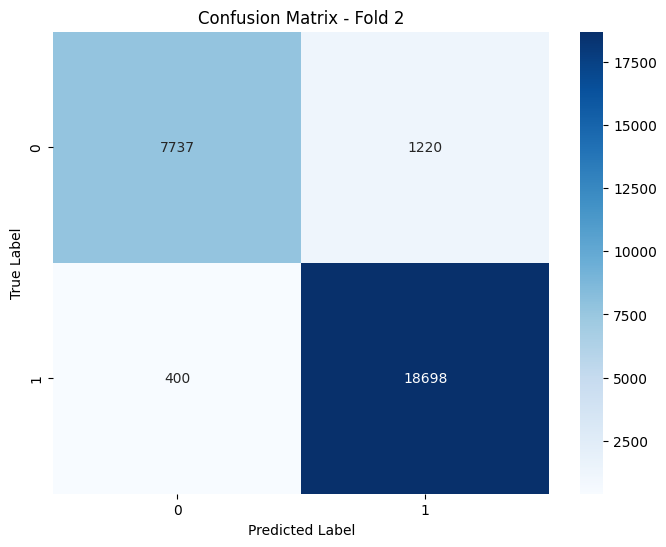


Classification Report - Fold 2
              precision    recall  f1-score   support

           0       0.95      0.86      0.91      8957
           1       0.94      0.98      0.96     19098

    accuracy                           0.94     28055
   macro avg       0.94      0.92      0.93     28055
weighted avg       0.94      0.94      0.94     28055


Fold 3/5
----------------------------------------


Epoch 1/20
Train Loss: 0.2272 - Train Acc: 0.9144 - Val Loss: 0.1651 - Val Acc: 0.9360
----------------------------------------


Epoch 2/20
Train Loss: 0.1700 - Train Acc: 0.9339 - Val Loss: 0.1532 - Val Acc: 0.9356
----------------------------------------


Epoch 3/20
Train Loss: 0.1579 - Train Acc: 0.9359 - Val Loss: 0.1454 - Val Acc: 0.9363
----------------------------------------


Epoch 4/20
Train Loss: 0.1496 - Train Acc: 0.9368 - Val Loss: 0.1379 - Val Acc: 0.9389
----------------------------------------


Epoch 5/20
Train Loss: 0.1451 - Train Acc: 0.9369 - Val Loss: 0.1360 - Val Acc: 0.9382
----------------------------------------


Epoch 6/20
Train Loss: 0.1405 - Train Acc: 0.9374 - Val Loss: 0.1385 - Val Acc: 0.9356
----------------------------------------


Epoch 7/20
Train Loss: 0.1386 - Train Acc: 0.9377 - Val Loss: 0.1359 - Val Acc: 0.9377
----------------------------------------


Epoch 8/20
Train Loss: 0.1354 - Train Acc: 0.9383 - Val Loss: 0.1297 - Val Acc: 0.9383
----------------------------------------


Epoch 9/20
Train Loss: 0.1339 - Train Acc: 0.9385 - Val Loss: 0.1256 - Val Acc: 0.9389
----------------------------------------


Epoch 10/20
Train Loss: 0.1317 - Train Acc: 0.9390 - Val Loss: 0.1284 - Val Acc: 0.9394
----------------------------------------


Epoch 11/20
Train Loss: 0.1293 - Train Acc: 0.9394 - Val Loss: 0.1243 - Val Acc: 0.9394
----------------------------------------


Epoch 12/20
Train Loss: 0.1279 - Train Acc: 0.9392 - Val Loss: 0.1211 - Val Acc: 0.9408
----------------------------------------


Epoch 13/20
Train Loss: 0.1253 - Train Acc: 0.9407 - Val Loss: 0.1185 - Val Acc: 0.9415
----------------------------------------


Epoch 14/20
Train Loss: 0.1238 - Train Acc: 0.9407 - Val Loss: 0.1193 - Val Acc: 0.9402
----------------------------------------


Epoch 15/20
Train Loss: 0.1233 - Train Acc: 0.9406 - Val Loss: 0.1182 - Val Acc: 0.9407
----------------------------------------


Epoch 16/20
Train Loss: 0.1229 - Train Acc: 0.9405 - Val Loss: 0.1176 - Val Acc: 0.9421
----------------------------------------


Epoch 17/20
Train Loss: 0.1217 - Train Acc: 0.9407 - Val Loss: 0.1188 - Val Acc: 0.9402
----------------------------------------


Epoch 18/20
Train Loss: 0.1211 - Train Acc: 0.9407 - Val Loss: 0.1162 - Val Acc: 0.9433
----------------------------------------


Epoch 19/20
Train Loss: 0.1201 - Train Acc: 0.9416 - Val Loss: 0.1165 - Val Acc: 0.9415
----------------------------------------


Epoch 20/20
Train Loss: 0.1201 - Train Acc: 0.9415 - Val Loss: 0.1155 - Val Acc: 0.9423
----------------------------------------


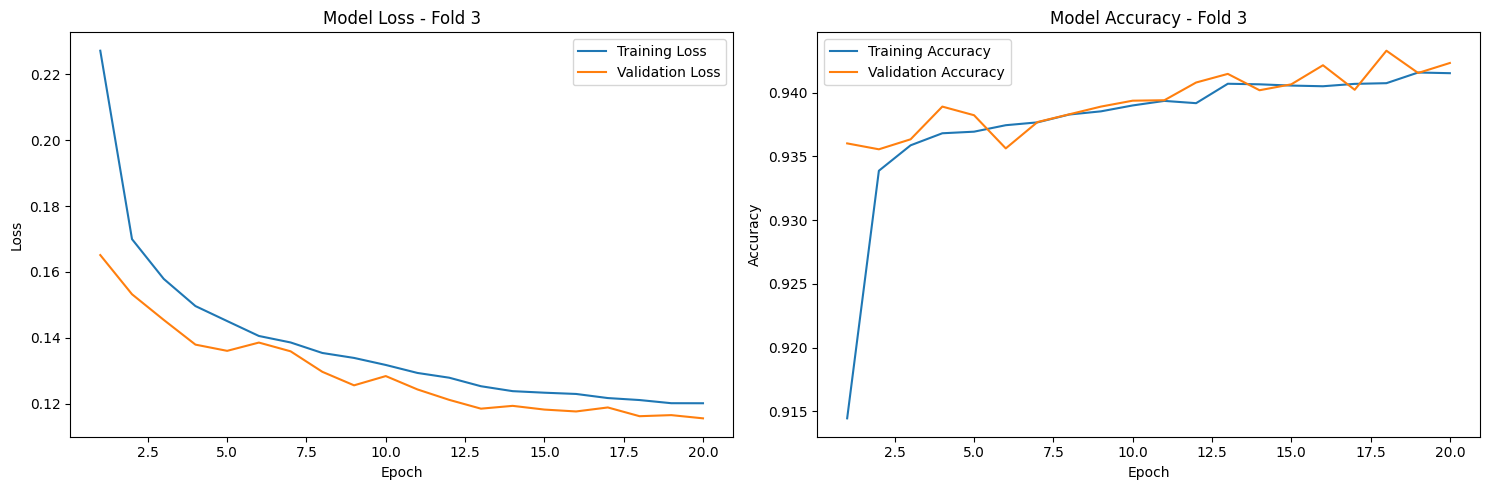

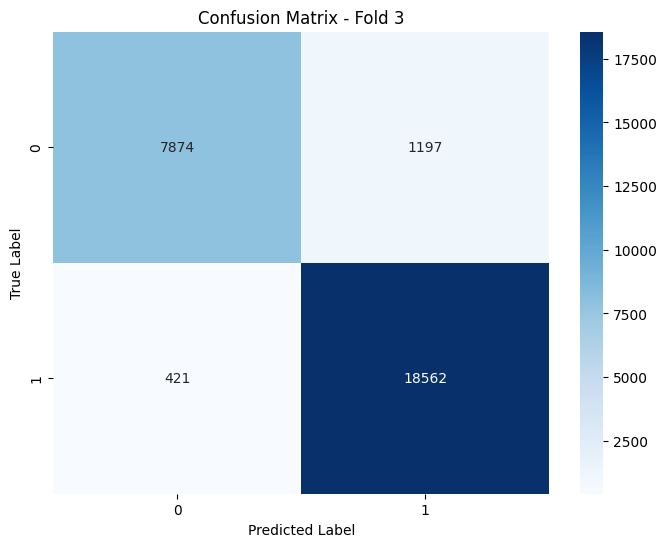


Classification Report - Fold 3
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      9071
           1       0.94      0.98      0.96     18983

    accuracy                           0.94     28054
   macro avg       0.94      0.92      0.93     28054
weighted avg       0.94      0.94      0.94     28054


Fold 4/5
----------------------------------------


Epoch 1/20
Train Loss: 0.2207 - Train Acc: 0.9164 - Val Loss: 0.1691 - Val Acc: 0.9330
----------------------------------------


Epoch 2/20
Train Loss: 0.1699 - Train Acc: 0.9336 - Val Loss: 0.1582 - Val Acc: 0.9361
----------------------------------------


Epoch 3/20
Train Loss: 0.1581 - Train Acc: 0.9365 - Val Loss: 0.1532 - Val Acc: 0.9363
----------------------------------------


Epoch 4/20
Train Loss: 0.1513 - Train Acc: 0.9373 - Val Loss: 0.1480 - Val Acc: 0.9367
----------------------------------------


Epoch 5/20
Train Loss: 0.1458 - Train Acc: 0.9372 - Val Loss: 0.1373 - Val Acc: 0.9367
----------------------------------------


Epoch 6/20
Train Loss: 0.1403 - Train Acc: 0.9377 - Val Loss: 0.1340 - Val Acc: 0.9383
----------------------------------------


Epoch 7/20
Train Loss: 0.1366 - Train Acc: 0.9384 - Val Loss: 0.1329 - Val Acc: 0.9383
----------------------------------------


Epoch 8/20
Train Loss: 0.1324 - Train Acc: 0.9384 - Val Loss: 0.1256 - Val Acc: 0.9396
----------------------------------------


Epoch 9/20
Train Loss: 0.1297 - Train Acc: 0.9391 - Val Loss: 0.1254 - Val Acc: 0.9408
----------------------------------------


Epoch 10/20
Train Loss: 0.1280 - Train Acc: 0.9393 - Val Loss: 0.1229 - Val Acc: 0.9406
----------------------------------------


Epoch 11/20
Train Loss: 0.1252 - Train Acc: 0.9401 - Val Loss: 0.1218 - Val Acc: 0.9416
----------------------------------------


Epoch 12/20
Train Loss: 0.1238 - Train Acc: 0.9401 - Val Loss: 0.1220 - Val Acc: 0.9412
----------------------------------------


Epoch 13/20
Train Loss: 0.1235 - Train Acc: 0.9404 - Val Loss: 0.1207 - Val Acc: 0.9415
----------------------------------------


Epoch 14/20
Train Loss: 0.1223 - Train Acc: 0.9404 - Val Loss: 0.1237 - Val Acc: 0.9414
----------------------------------------


Epoch 15/20
Train Loss: 0.1236 - Train Acc: 0.9400 - Val Loss: 0.1203 - Val Acc: 0.9425
----------------------------------------


Epoch 16/20
Train Loss: 0.1215 - Train Acc: 0.9407 - Val Loss: 0.1320 - Val Acc: 0.9392
----------------------------------------


Epoch 17/20
Train Loss: 0.1209 - Train Acc: 0.9408 - Val Loss: 0.1220 - Val Acc: 0.9383
----------------------------------------


Epoch 18/20
Train Loss: 0.1205 - Train Acc: 0.9413 - Val Loss: 0.1201 - Val Acc: 0.9420
----------------------------------------


Epoch 19/20
Train Loss: 0.1213 - Train Acc: 0.9411 - Val Loss: 0.1223 - Val Acc: 0.9410
----------------------------------------


Epoch 20/20
Train Loss: 0.1200 - Train Acc: 0.9412 - Val Loss: 0.1199 - Val Acc: 0.9415
----------------------------------------


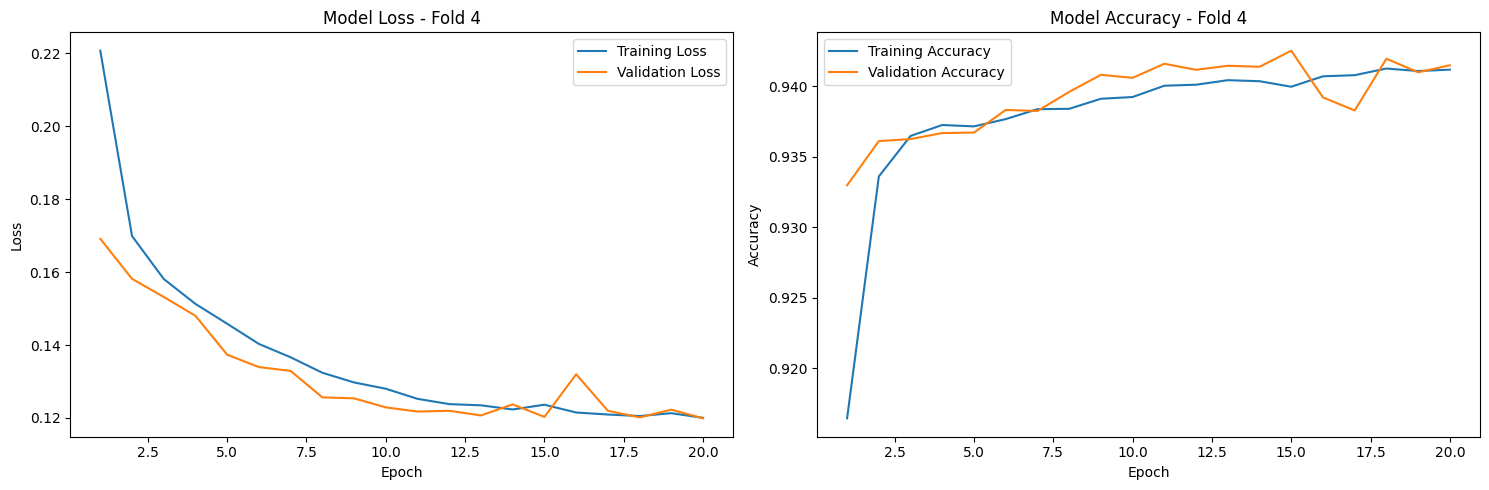

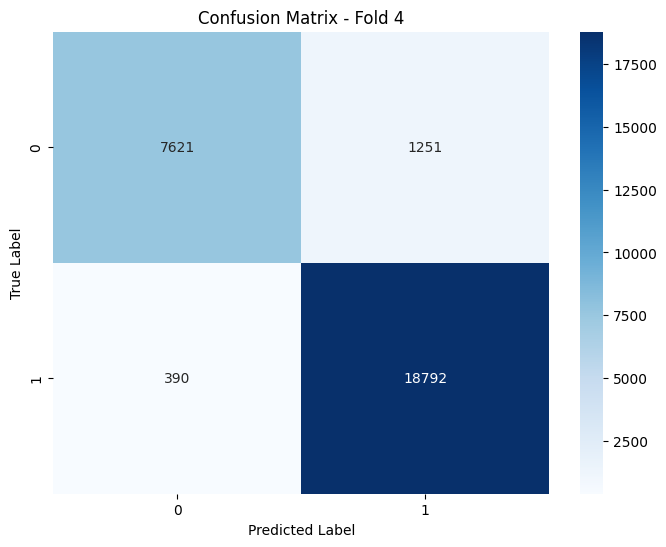


Classification Report - Fold 4
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      8872
           1       0.94      0.98      0.96     19182

    accuracy                           0.94     28054
   macro avg       0.94      0.92      0.93     28054
weighted avg       0.94      0.94      0.94     28054


Fold 5/5
----------------------------------------


Epoch 1/20
Train Loss: 0.2260 - Train Acc: 0.9143 - Val Loss: 0.1605 - Val Acc: 0.9374
----------------------------------------


Epoch 2/20
Train Loss: 0.1706 - Train Acc: 0.9340 - Val Loss: 0.1512 - Val Acc: 0.9384
----------------------------------------


Epoch 3/20
Train Loss: 0.1606 - Train Acc: 0.9351 - Val Loss: 0.1585 - Val Acc: 0.9380
----------------------------------------


Epoch 4/20
Train Loss: 0.1527 - Train Acc: 0.9357 - Val Loss: 0.1465 - Val Acc: 0.9392
----------------------------------------


Epoch 5/20
Train Loss: 0.1467 - Train Acc: 0.9361 - Val Loss: 0.1370 - Val Acc: 0.9412
----------------------------------------


Epoch 6/20
Train Loss: 0.1402 - Train Acc: 0.9372 - Val Loss: 0.1245 - Val Acc: 0.9405
----------------------------------------


Epoch 7/20
Train Loss: 0.1360 - Train Acc: 0.9377 - Val Loss: 0.1230 - Val Acc: 0.9418
----------------------------------------


Epoch 8/20
Train Loss: 0.1330 - Train Acc: 0.9379 - Val Loss: 0.1217 - Val Acc: 0.9402
----------------------------------------


Epoch 9/20
Train Loss: 0.1300 - Train Acc: 0.9385 - Val Loss: 0.1222 - Val Acc: 0.9421
----------------------------------------


Epoch 10/20
Train Loss: 0.1290 - Train Acc: 0.9381 - Val Loss: 0.1210 - Val Acc: 0.9411
----------------------------------------


Epoch 11/20
Train Loss: 0.1272 - Train Acc: 0.9391 - Val Loss: 0.1192 - Val Acc: 0.9427
----------------------------------------


Epoch 12/20
Train Loss: 0.1254 - Train Acc: 0.9393 - Val Loss: 0.1267 - Val Acc: 0.9420
----------------------------------------


Epoch 13/20
Train Loss: 0.1248 - Train Acc: 0.9396 - Val Loss: 0.1175 - Val Acc: 0.9426
----------------------------------------


Epoch 14/20
Train Loss: 0.1241 - Train Acc: 0.9397 - Val Loss: 0.1188 - Val Acc: 0.9434
----------------------------------------


Epoch 15/20
Train Loss: 0.1233 - Train Acc: 0.9399 - Val Loss: 0.1179 - Val Acc: 0.9431
----------------------------------------


Epoch 16/20
Train Loss: 0.1232 - Train Acc: 0.9401 - Val Loss: 0.1186 - Val Acc: 0.9428
----------------------------------------


Epoch 17/20
Train Loss: 0.1233 - Train Acc: 0.9400 - Val Loss: 0.1153 - Val Acc: 0.9439
----------------------------------------


Epoch 18/20
Train Loss: 0.1217 - Train Acc: 0.9401 - Val Loss: 0.1166 - Val Acc: 0.9418
----------------------------------------


Epoch 19/20
Train Loss: 0.1209 - Train Acc: 0.9409 - Val Loss: 0.1147 - Val Acc: 0.9445
----------------------------------------


Epoch 20/20
Train Loss: 0.1204 - Train Acc: 0.9404 - Val Loss: 0.1225 - Val Acc: 0.9415
----------------------------------------


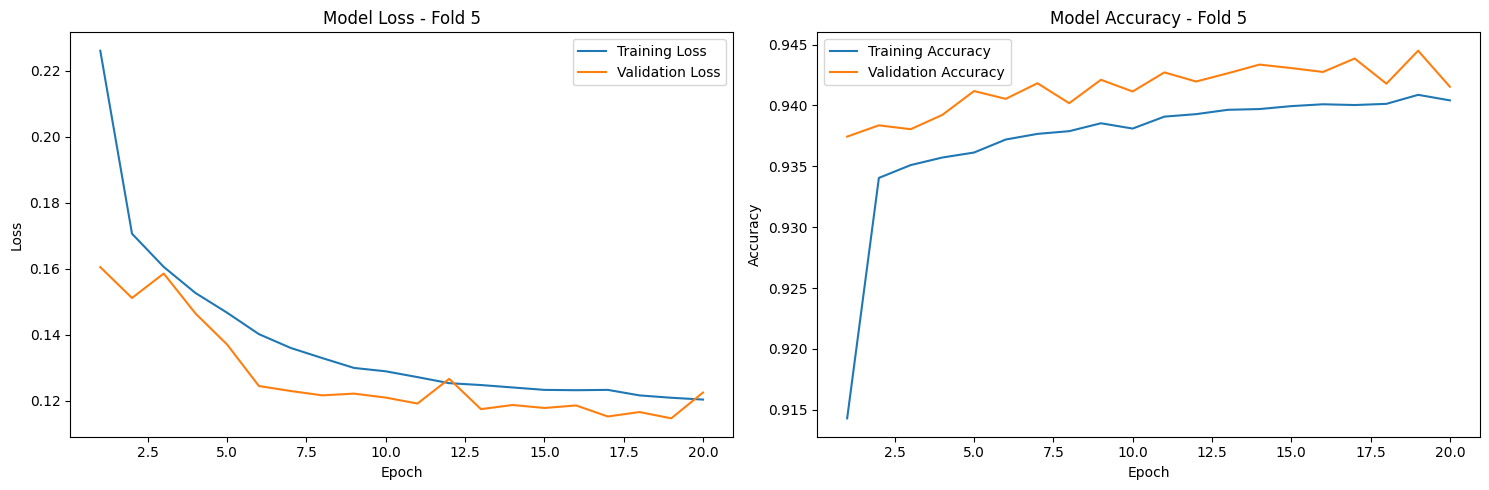

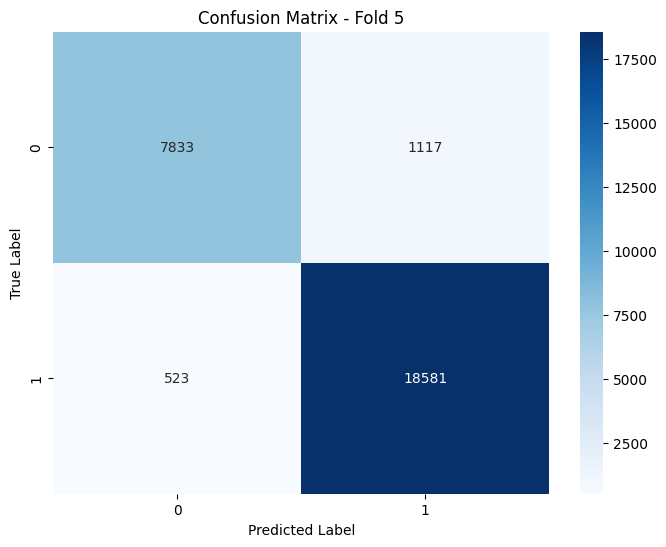


Classification Report - Fold 5
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      8950
           1       0.94      0.97      0.96     19104

    accuracy                           0.94     28054
   macro avg       0.94      0.92      0.93     28054
weighted avg       0.94      0.94      0.94     28054


Final Report
Best Fold: 3
Best Accuracy: 0.9423
Best Precision: 0.9426
Best Recall: 0.9423
Best F1 Score: 0.9416
Best Specificity: 0.8680
Best ROC-AUC: 0.9890


In [11]:
# Calculate dimensions for each modality
modality_dims = {
    modality: data.shape[1]
    for modality, data in processed_train_data.items()
}

# Create model
model = MultiModalBertTransformer(modality_dims).to(device)

# Convert training data to tensors
tensor_train_data = {
    modality: torch.FloatTensor(data)
    for modality, data in processed_train_data.items()
}
tensor_train_labels = torch.LongTensor(train_labels)

# Create dataset
train_dataset = MultiModalDataset(tensor_train_data, tensor_train_labels)

# Train model with k-fold cross validation
model, history = train_model_with_kfold(
    model, train_dataset, n_splits=5, num_epochs=20
)

In [12]:
def evaluate_test_data(
    model: nn.Module,
    test_data: Dict[str, np.ndarray],
    test_labels: np.ndarray,
    device: torch.device
) -> None:
    # Prepare test data
    tensor_test_data = {
        modality: torch.FloatTensor(data)
        for modality, data in test_data.items()
    }
    tensor_test_labels = torch.LongTensor(test_labels)
    
    # Create test dataset and dataloader
    test_dataset = MultiModalDataset(tensor_test_data, tensor_test_labels)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Set model to evaluation mode
    model.eval()
    
    # Initialize lists to store predictions and probabilities
    all_preds = []
    all_labels = []
    all_probs = []
    
    # Evaluate model
    with torch.no_grad():
        for batch_data, labels in tqdm(test_loader, desc="Testing"):
            # Move data to device
            batch_data = {
                modality: features.to(device).float()
                for modality, features in batch_data.items()
            }
            
            # Get model predictions
            outputs = model(batch_data)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)
            
            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    specificity = confusion_matrix(all_labels, all_preds)[0, 0] / (
        confusion_matrix(all_labels, all_preds)[0, 0] + 
        confusion_matrix(all_labels, all_preds)[0, 1]
    )
    roc_auc = roc_auc_score(all_labels, all_probs)
    
    # Print results
    print("\nTest Set Evaluation Results")
    print("=" * 40)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Test Set Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()